In [1]:
import pandas as pd
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, classification_report
)

print("Libraries for training imported successfully.")

Libraries for training imported successfully.


In [4]:
# Load the balanced dataset
df_balanced = pd.read_csv("E:/lightGBM model/data/Train_balanced.csv")

# Define and apply the feature mapping
feature_mapping = {
    "feature_0": "Customer_Age", "feature_1": "Customer_Income",
    "feature_2": "Premium_Amount", "feature_3": "Tenure_Years",
    "feature_4": "Avg_Claim_Amount", "feature_5": "Num_Claims",
    "feature_6": "Policy_Cost", "feature_7": "Region",
    "feature_8": "Gender", "feature_9": "Marital_Status",
    "feature_10": "Num_Dependents", "feature_11": "Satisfaction_Score",
    "feature_12": "Loyalty_Score", "feature_13": "Years_with_Company",
    "feature_14": "Policy_Type", "feature_15": "Contact_Frequency"
}
df_balanced.rename(columns=feature_mapping, inplace=True)

# Define feature types again for this notebook
numerical_features = [
    "Customer_Age", "Customer_Income", "Premium_Amount", "Tenure_Years",
    "Avg_Claim_Amount", "Num_Claims", "Policy_Cost", "Years_with_Company"
]
categorical_features = [
    "Region", "Gender", "Marital_Status", "Num_Dependents",
    "Satisfaction_Score", "Loyalty_Score", "Policy_Type", "Contact_Frequency"
]
target = "labels"

print("Balanced data loaded and prepared.")

Balanced data loaded and prepared.


In [5]:
# Separate features (X) and target (y)
X = df_balanced.drop(target, axis=1)
y = df_balanced[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (47905, 16)
Testing set shape: (11977, 16)


In [7]:
# Label Encode Categorical Features
for col in categorical_features:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    # Save the encoder
    joblib.dump(le, f"../models/le_{col}.pkl")
print("Categorical features encoded and encoders saved.")

# Scale Numerical Features
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])
# Save the scaler
joblib.dump(scaler, "../models/scaler.pkl")
print("Numerical features scaled and scaler saved.")

Categorical features encoded and encoders saved.
Numerical features scaled and scaler saved.


In [8]:
# Define model parameters
lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 50,
    'learning_rate': 0.03,
    'n_estimators': 1000, # We'll use early stopping, so a high number is fine
    'verbose': -1
}

# Initialize and train the model
model_lgb = lgb.LGBMClassifier(**lgb_params)

model_lgb.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              eval_metric='auc',
              callbacks=[lgb.early_stopping(100, verbose=True)])

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[999]	valid_0's auc: 0.991746


,boosting_type,'gbdt'
,num_leaves,50
,max_depth,-1
,learning_rate,0.03
,n_estimators,1000
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [9]:
# Make predictions
y_pred_proba = model_lgb.predict_proba(X_test)[:, 1]
y_pred_class = (y_pred_proba >= 0.5).astype(int)

# Print metrics
print("\n--- Model Evaluation ---")
print(f"Accuracy : {accuracy_score(y_test, y_pred_class):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_class):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_class):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred_class):.4f}")
print(f"ROC-AUC  : {roc_auc_score(y_test, y_pred_proba):.4f}\n")
print("--- Classification Report ---")
print(classification_report(y_test, y_pred_class))


--- Model Evaluation ---
Accuracy : 0.9492
Precision: 0.9541
Recall   : 0.9439
F1-score : 0.9490
ROC-AUC  : 0.9917

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.94      0.95      0.95      5989
           1       0.95      0.94      0.95      5988

    accuracy                           0.95     11977
   macro avg       0.95      0.95      0.95     11977
weighted avg       0.95      0.95      0.95     11977



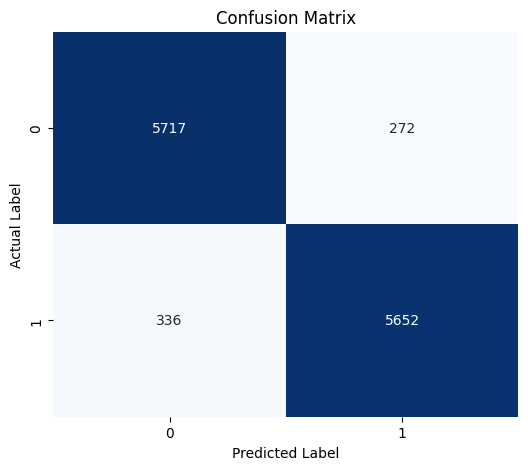

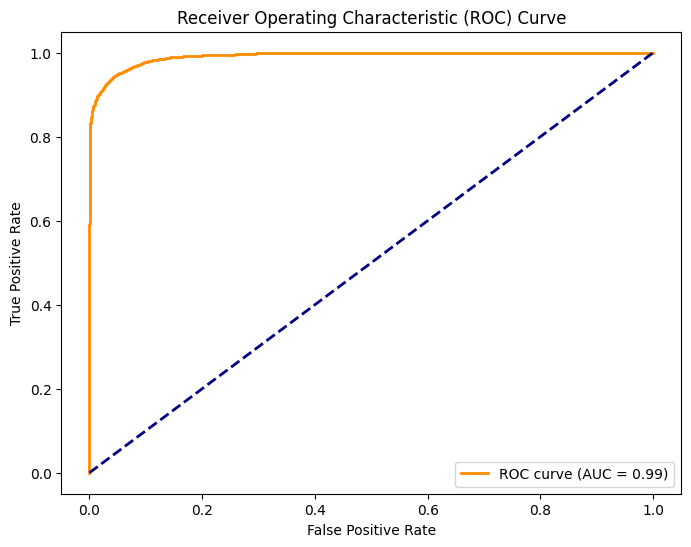

In [10]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred_class)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

# Plot ROC-AUC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

✅ Model metrics saved to '../models/model_metrics.json'
✅ Confusion matrix plot saved to '../models/confusion_matrix.png'
✅ Trained LightGBM model saved successfully to '../models/lightgbm_churn_model.pkl'


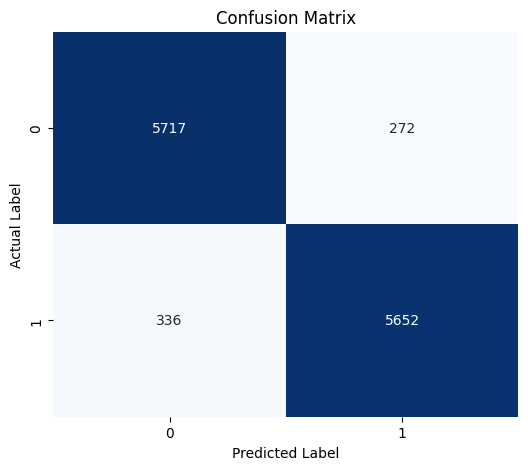

In [12]:
# ... existing code ...

# --- 8. Save Metrics and Final Model ---
# Create a dictionary with all the performance metrics
metrics = {
    "Accuracy": f"{accuracy_score(y_test, y_pred_class):.2%}",
    "Precision": f"{precision_score(y_test, y_pred_class):.2%}",
    "Recall": f"{recall_score(y_test, y_pred_class):.2%}",
    "F1-score": f"{f1_score(y_test, y_pred_class):.2%}",
    "ROC-AUC": f"{roc_auc_score(y_test, y_pred_proba):.3f}"
}

# Save the metrics to a JSON file
import json
with open("../models/model_metrics.json", "w") as f:
    json.dump(metrics, f)
print("✅ Model metrics saved to '../models/model_metrics.json'")

# Save the confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.savefig("../models/confusion_matrix.png") # Save the figure
print("✅ Confusion matrix plot saved to '../models/confusion_matrix.png'")


# Save the final model
joblib.dump(model_lgb, "../models/lightgbm_churn_model.pkl")
print("✅ Trained LightGBM model saved successfully to '../models/lightgbm_churn_model.pkl'")


In [11]:
# Save the final model to the models folder
joblib.dump(model_lgb, "../models/lightgbm_churn_model.pkl")

print("✅ Trained LightGBM model saved successfully to '../models/lightgbm_churn_model.pkl'")

✅ Trained LightGBM model saved successfully to '../models/lightgbm_churn_model.pkl'
